# Shuffling in Python

* by abram hindle <abram.hindle@softwareprocess.es>

I want to shuffle some videos such that everyday I can watch a video and make sure it hasn't repeated recently. Given 7 videos I should only see each video once this week.

To do this I need to understand how random numbers are generated, and how to shuffle a list.

Today we'll talk about:
* random numbers, 
* linear congruential generators, 
* shuffling, 
* fisher yates shuffle,
* maintaining a shuffle

# Random Numbers

Random numbers are numbers pulled or generated from a set or distribution of numbers. They are supposed follow ideas of randomness such as not repeating, or they are meant to simulate stochastic or random processes in real life (like dice, coin flips, or chance of radioactive emmission).

Computers are meant to compute deterministicly and this determinism is often a barrier to generating random numbers.

In [254]:
import random
from collections import Counter

def rep_print(f, n=10, no_counter=False):
    l = [f() for i in range(n)]
    print(l[0:100])
    if no_counter:
        return
    c = Counter(l)
    print(c)
    

def my_random():
    return 4

def not_random():
    return random.randint(0,0)

def this_looks_random():
    return random.randint(0,1)

def this_looks_floating_point_random():
    return random.random()

In [255]:
print("my_random")
rep_print(my_random)
print("not_random")
rep_print(not_random)
print("this_looks_random")
rep_print(this_looks_random)
print("this_looks_floating_point_random")
rep_print(this_looks_floating_point_random,no_counter=True)

my_random
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Counter({4: 10})
not_random
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Counter({0: 10})
this_looks_random
[0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Counter({0: 6, 1: 4})
this_looks_floating_point_random
[0.2306700302556649, 0.35745337810085087, 0.5082680609633805, 0.6116365638724249, 0.5849004769494317, 0.24367134202978868, 0.7512734218714772, 0.435632434890868, 0.3719582092613749, 0.6021775002242169]


# Linear congruential generators (LCGs)

* LCGs are a very computationally cheap method of generating a series of random numbers.
* It is stateful, it is started with a seed, and keeps track of previous values to make the new value.
* `new_random_value = ( old_random_value * multiplier + increment ) % modulus`
  * where seed is the initial `old_random_value`
* `increment` and `modulus` should be relatively prime
* Wikipedia: https://en.wikipedia.org/wiki/Linear_congruential_generator

In [256]:
old_random_value = 1
multiplier = 75
increment = 74
modulus = 2**16 + 1
new_random_value = ( old_random_value * multiplier + increment ) % modulus
new_random_value

149

In [257]:
randoms = []
for i in range(100000):
    new_random_value = ( old_random_value * multiplier + increment ) % modulus
    old_random_value = new_random_value
    randoms.append( old_random_value )
print( randoms[0:100] )

[149, 11249, 57305, 38044, 35283, 24819, 26463, 18689, 25472, 9901, 21742, 57836, 12332, 7456, 34978, 1944, 14800, 61482, 23634, 3125, 37838, 19833, 45735, 22275, 32274, 61292, 9384, 48504, 33339, 10093, 36142, 23707, 8600, 55241, 14318, 25332, 64938, 20686, 44173, 36199, 27982, 1540, 50037, 17240, 47871, 51401, 54003, 52542, 8504, 48041, 64151, 27198, 8277, 31016, 32479, 11130, 48380, 24039, 33500, 22168, 24249, 49250, 23752, 11975, 46218, 58500, 62132, 6847, 54840, 49780, 63502, 44060, 27724, 47727, 40601, 30447, 55341, 21818, 63536, 46610, 22363, 38874, 31996, 40442, 18522, 12947, 53581, 20892, 59623, 15283, 32170, 53492, 14217, 17757, 21109, 10361, 56242, 23856, 19775, 41385]


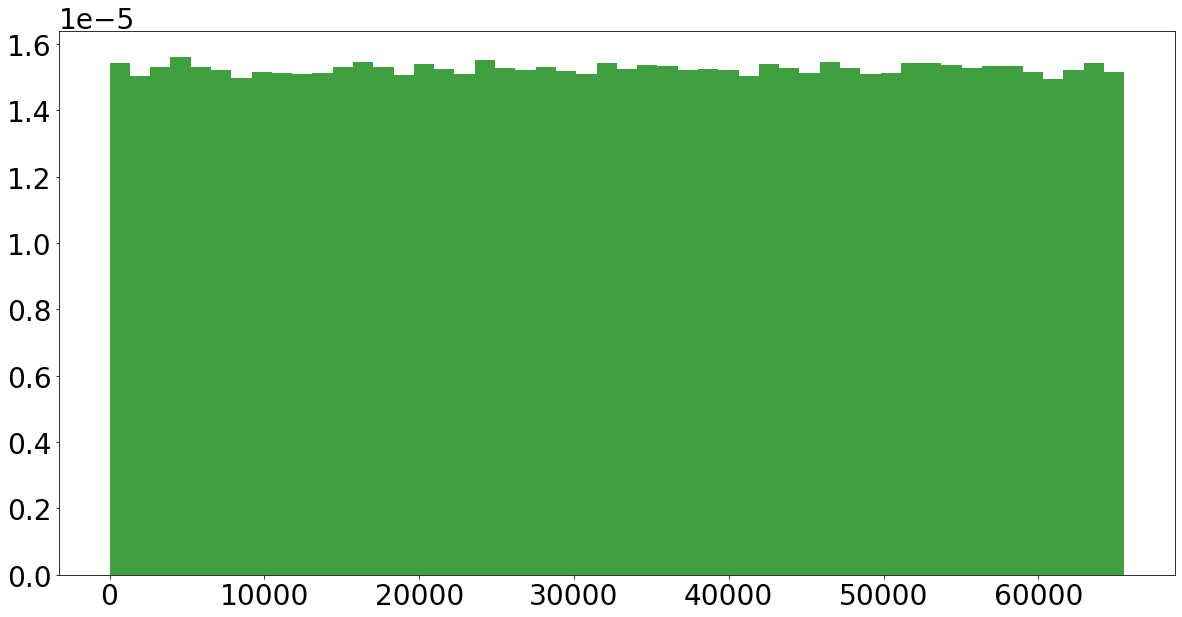

In [258]:
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize":(20,10)})
plt.rcParams.update({'font.size': 28})
plt.hist(randoms, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

In [259]:
def show_dist(l,bins=50):
    plt.hist(l, bins, density=True, facecolor='g', alpha=0.75)
    plt.show()

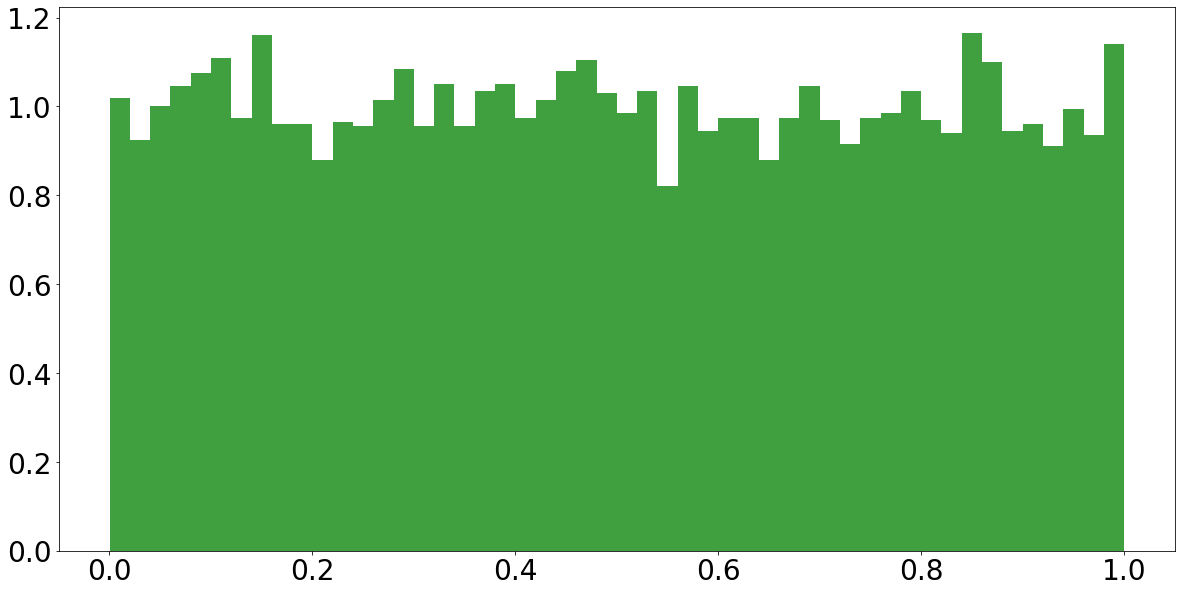

In [260]:
show_dist([random.random() for i in range(10000)])

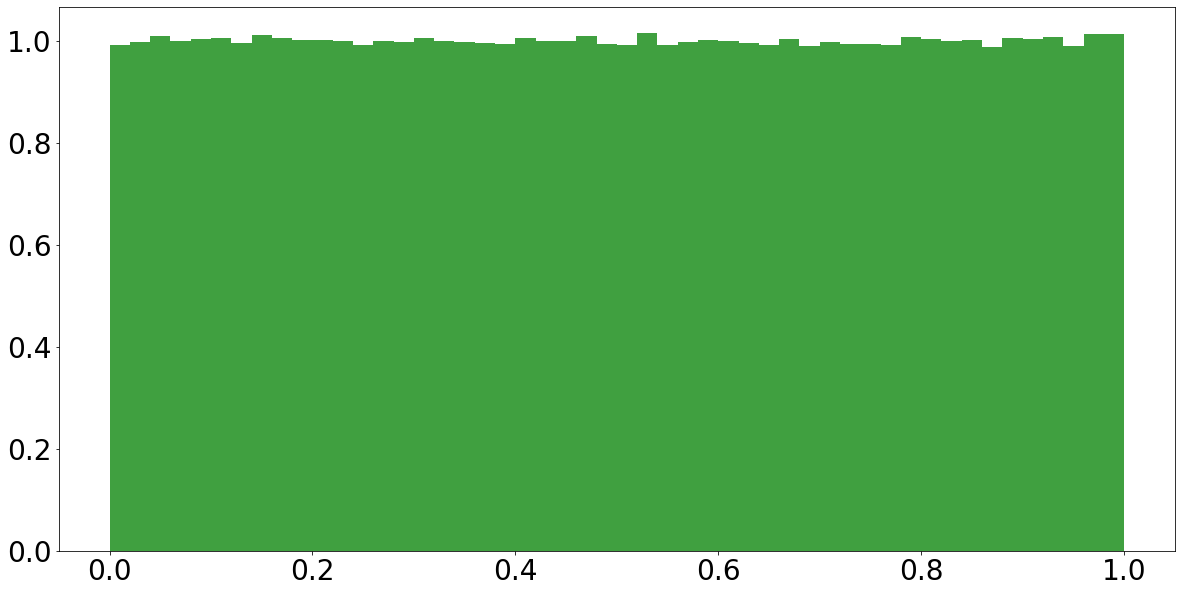

In [261]:
show_dist([random.random() for i in range(1000000)])

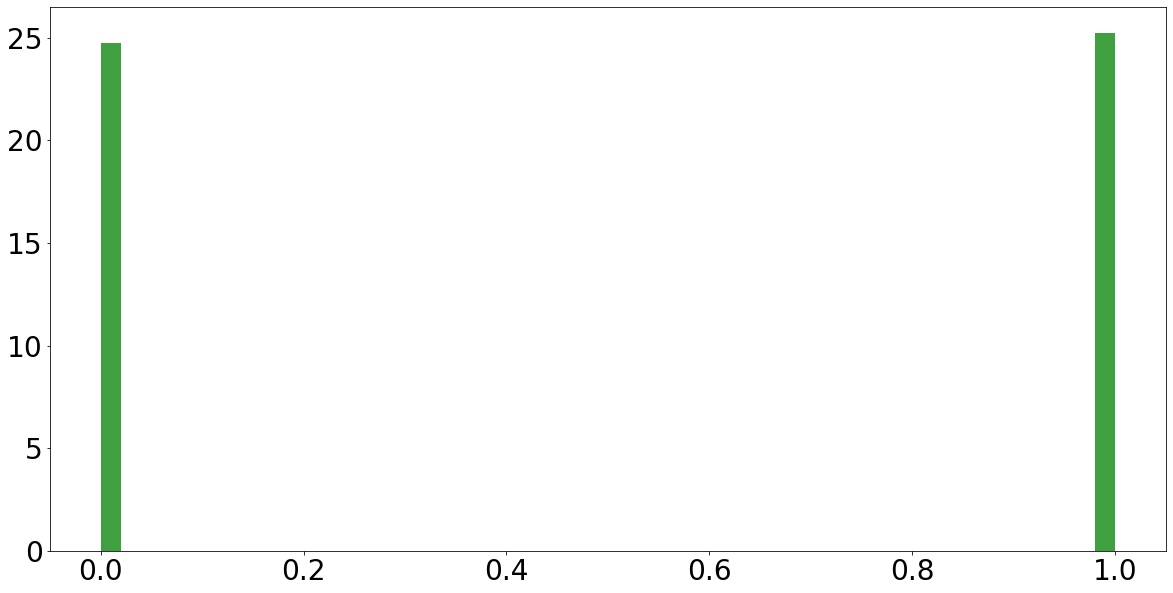

In [262]:
show_dist([random.randint(0,1) for i in range(10000)])

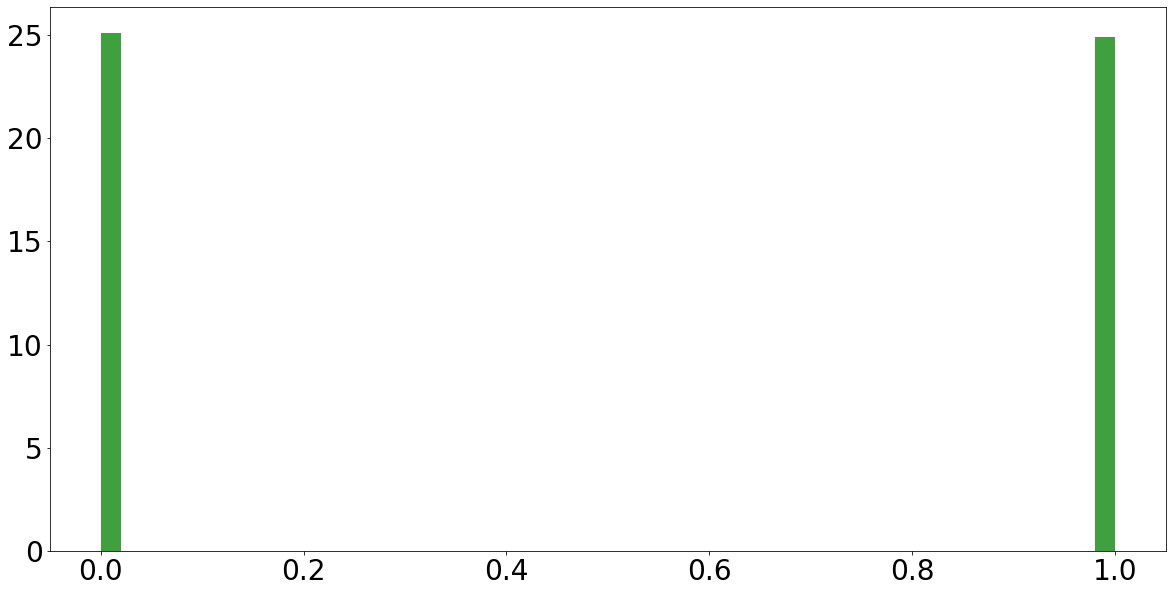

In [263]:
show_dist([random.randint(0,1) for i in range(100000)])

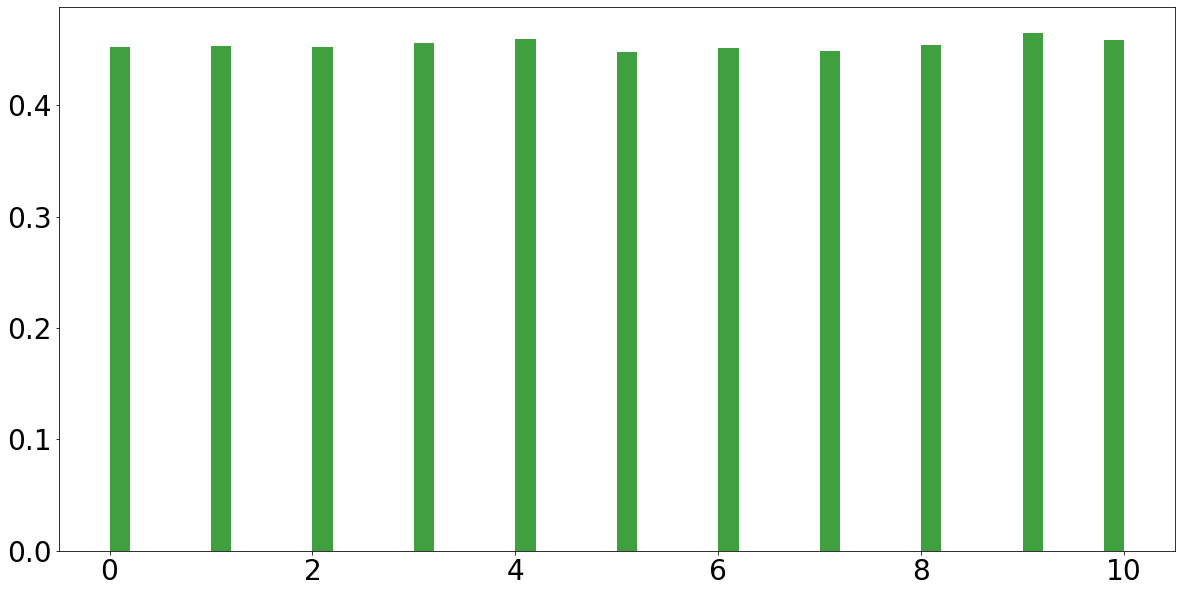

In [264]:
show_dist([random.randint(0,10) for i in range(100000)])

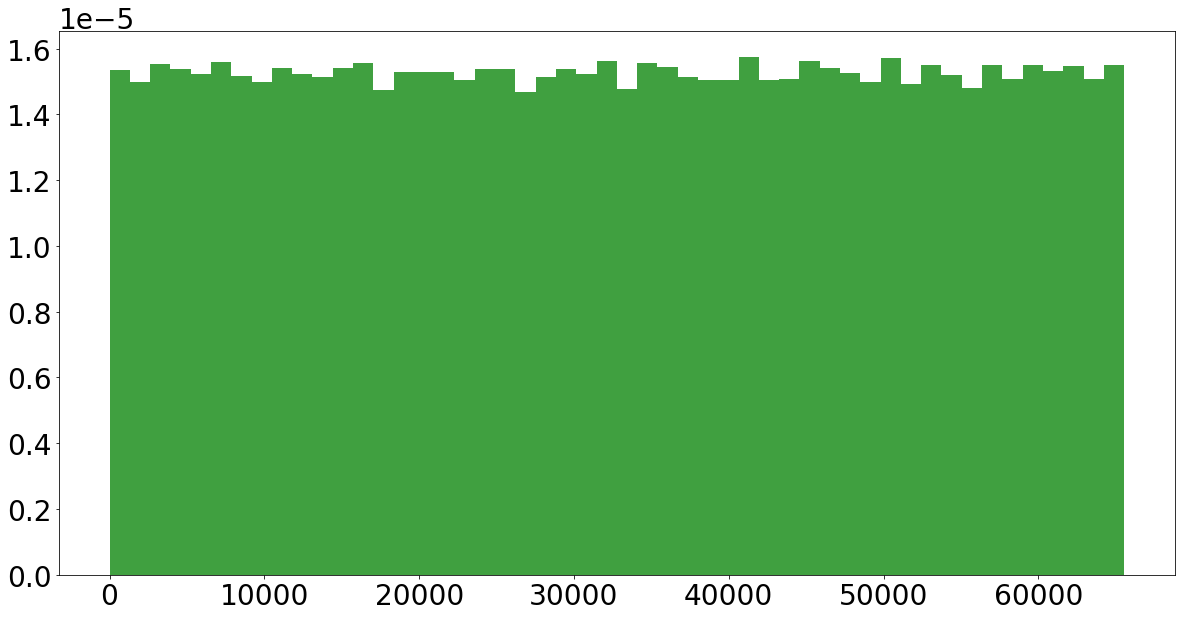

In [265]:
show_dist([random.randint(0,65535) for i in range(100000)])

In [ ]:
We can eyeball it, but we can also use a statistical test.

In [ ]:
# taken from StuartGordonReid from https://gist.github.com/StuartGordonReid/54845bf66de7e195b335/revisions
from numpy.fft import fft
import numpy
from scipy.special import erfc
# only handles 0s and 1s.
def spectral(bin_data):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the peak heights in the Discrete Fourier Transform of the sequence. The purpose of
    this test is to detect periodic features (i.e., repetitive patterns that are near each other) in the tested
    sequence that would indicate a deviation from the assumption of randomness. The intention is to detect whether
    the number of peaks exceeding the 95 % threshold is significantly different than 5 %.
    :param bin_data: a binary string
    :return: the p-value from the test
    """
    n = len(bin_data)
    plus_minus_one = [-1 if i == 0 else 1 for i in bin_data ]
    # Product discrete fourier transform of plus minus one
    s = fft(plus_minus_one)
    modulus = numpy.abs(s[0:n // 2])
    tau = numpy.sqrt(numpy.log(1 / 0.05) * n)
    # Theoretical number of peaks
    count_n0 = 0.95 * (n / 2)
    # Count the number of actual peaks m > T
    count_n1 = len(numpy.where(modulus < tau)[0])
    # Calculate d and return the p value statistic
    d = (count_n1 - count_n0) / numpy.sqrt(n * 0.95 * 0.05 / 4)
    p_val = erfc(abs(d) / numpy.sqrt(2))
    return p_val

In [ ]:
spectral([random.randint(0,1) for i in range(32000)])

In [ ]:
spectral([0 for i in range(32000)])

In [ ]:
spectral([1 for i in range(32000)])

In [ ]:
spectral([1 if i % 2 == 0 else 0 for i in range(32000)])

In [ ]:
last_bits = [i%2 for i in randoms]
print(last_bits[:100])
spectral( last_bits )

In [ ]:
def lcg(seed, multiplier:int, increment:int, modulus:int, n = 10000):
    old_random_value = seed
    randoms = []
    for i in range(n):
        new_random_value = ( old_random_value * multiplier + increment ) % modulus
        old_random_value = new_random_value
        randoms.append( old_random_value )
    return randoms
def binarize(l,bit=0):
    return [(i>>bit)%2 for i in l ]

In [ ]:
spectral( binarize(lcg(12313,134775813,1,2**32))) # turbo pascal

In [ ]:
[spectral( binarize(lcg(12313,48271,0,2**32-1),i)) for i in range(32)]  # C++11's minstd_rand

In [ ]:
[spectral( binarize(lcg(12313,214013,2531011,2**32),i)) for i in range(32)]  # MS Visual C

In [ ]:
[spectral( binarize(lcg(12313,6364136223846793005,1442695040888963407,2**64),i)) for i in range(32)]  # Knuth MMIX

In [ ]:
[spectral( binarize(lcg(12313,25214903917,11,2**48),i)) for i in range(32)]  # Java POSIX

# Moral of the story

Randomness is fraught with difficulty and tough math. Maybe just trust the random module in python.


# Let's get down to shuffling

* Take a list of elements and produce another list of the same size where all the elements appear in that list, hopefully in a different order.
* Given a position in the original list i, that element should occur at equal probability for all positions j in the output list.


In [ ]:
n = 10
l = list(range(10))
print(l)

In [ ]:
sorted(l)

In [267]:
sorted(l,key=lambda x: random.random())

[7, 1, 6, 4, 9, 2, 8, 5, 3, 0]

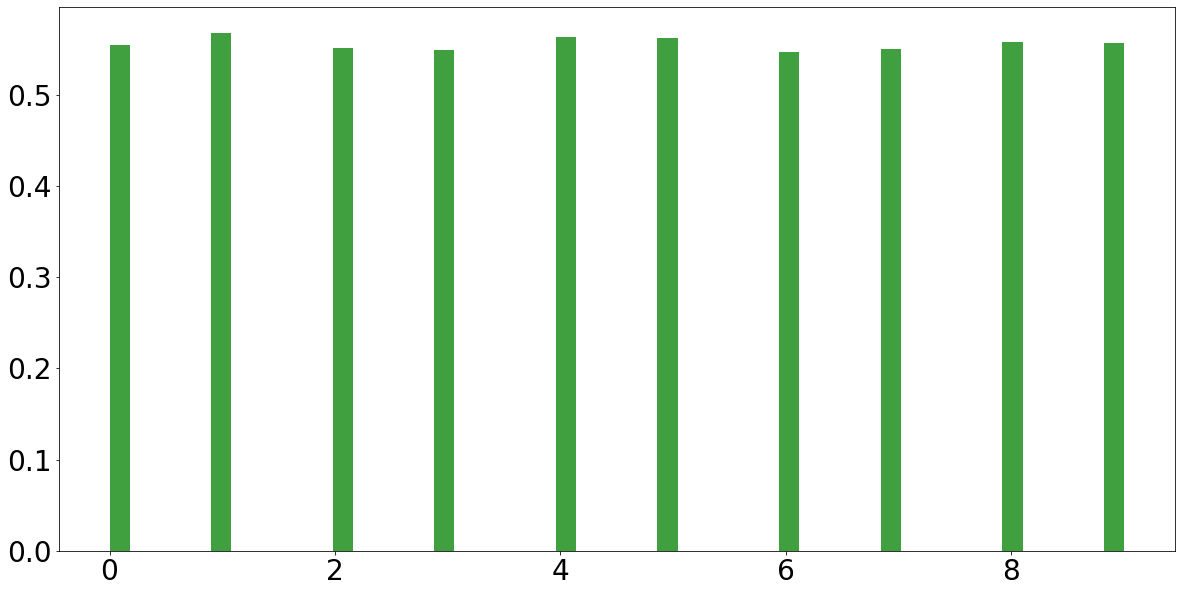

In [268]:
show_dist([sorted(l,key=lambda x: random.random())[0] for i in range(100000)])

In [269]:
spectral(binarize([sorted(l,key=lambda x: random.random())[0] for i in range(100000)]))

0.6014316046391459

Seems safe enough.

# It's not a great idea to use sort to shuffle.

* Depends on sort, depends on comparison.

In [270]:
# if you use sort you can generate random values to sort

[x for _,x in sorted(zip([random.random() for i in l],l))]

[8, 4, 6, 0, 3, 2, 9, 1, 7, 5]

# But that's an ineffecient shuffle

* O(n log n) at best.
* O(n) extra memory needed.


# Think about effecient shuffling
* Shuffling without sorting

Consider how we might shuffle.
* Choose one element from our list at random
  * remove it, and  
  * add it to another list.
* repeat until our initial list is empty

But now I have to modify the initial list and remove elements from it.

What about:
* for each element in order
  * swap it with an random element ahead of it

This way we already know where we visited by ignoring where we have been.
* Element 0 can be swapped to any location.
* Element 1 could already be swapped with element 0, or any element after it
* Element 2 could already be swapped with elements before, or after.

Wikipedia https://en.wikipedia.org/wiki/Fisher%E2%80%93Yates_shuffle

In [271]:
def fisher_yates(l):
    """ warning: mutates original list """
    n = len(l)
    for i in range(len(l)-1):
        j = random.randint(i,n-1)
        l[i],l[j] = l[j],l[i]
    return l

In [272]:
fisher_yates(list(range(10)))

[0, 3, 8, 9, 7, 4, 2, 6, 1, 5]

0.2829549868705389
0.5813855788250666
0.08687382851732293
0.4505518664342605
0.5422593047071815
0.9537182802419015
0.13888083923540914
0.023605752803918568
1.0
0.5044923041862102


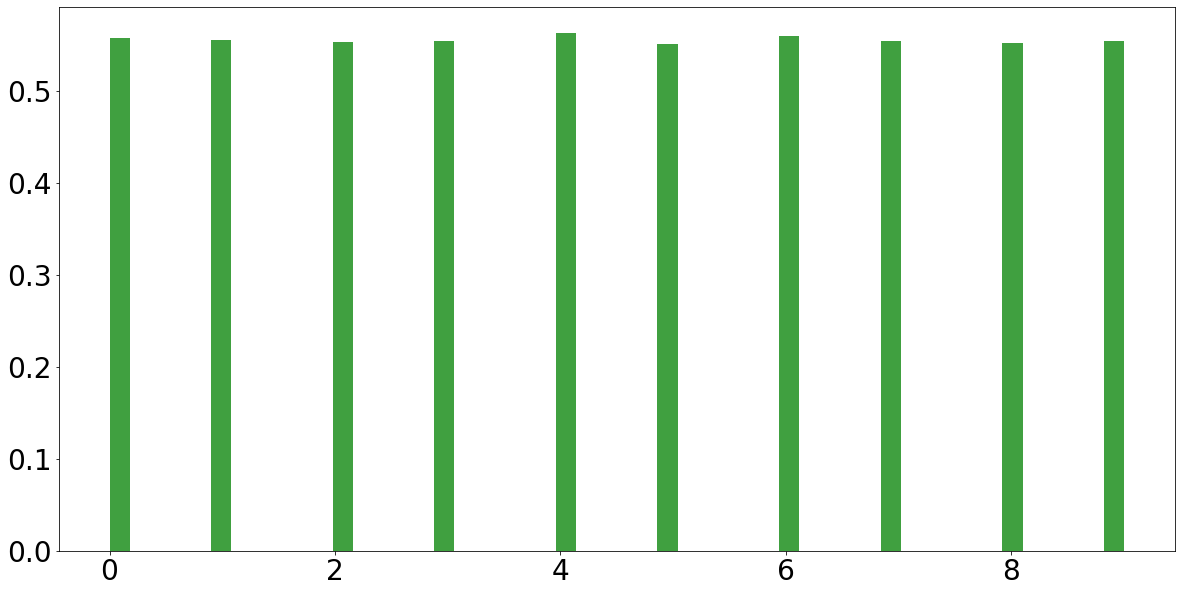

In [273]:
indice = 0
for indice in range(10):
    dist = [fisher_yates(list(range(10)))[indice] for i in range(100000)]
    #show_dist(dist)
    print(spectral(binarize(dist)))
show_dist(dist)

In [ ]:
indice = 0
def builtin_shuffle(l):
    random.shuffle(l) # in place shuffle
    return l

for indice in range(10):
    dist = [builtin_shuffle(list(range(10)))[indice] for i in range(100000)]
    #show_dist(dist)
    print(spectral(binarize(dist)))
show_dist(dist)

In [ ]:
def bad_fisher_yates(l):
    """ warning: mutates original list """
    n = len(l)
    for i in range(len(l)-1):
        j = random.randint(0,n-1)
        l[i],l[j] = l[j],l[i]
    return l

In [ ]:
indice = 0
for j in range(10):
    dist = [bad_fisher_yates(list(range(10)))[j] for i in range(100000)]
    show_dist(dist)
    print(spectral(binarize(dist)))

Yeah some of those indices are not very random

# Problem: I want a playlist generator but...

* I want to watch a different video each day. 
* I want the order to be random.
* I don't want it to repeat video 1 a lot.
* I want each video to play once per time unit (say 1 week)
* I don't want to see the same video twice in a row IN the same week (starts and ends are ok).
* Given videos 1,2,3,4,5 I don't want to see a sequence of 1,2,1,3,1,4,5,1,2,3
* I don't want to remember anything. No saving to disk.

Shuffling guarantees that each video only appears once. But how can I shuffle repeatedly?

In [ ]:
videos = ["Chungus","Friday","Dogs","Cats","PythonTutorial","MathVideo","Rickroll"]
# for instance
[("Week1",fisher_yates([x for x in videos])), ("Week2",fisher_yates([x for x in videos]))]

* What I really need is for all the days in this week to have the same shuffle.
* How do I get the same shuffle?


In [ ]:
# Look what happens when the same initial conditions are met
print("Stateful randomness, different initial conditions.")
print(fisher_yates([x for x in videos]))
print(fisher_yates([x for x in videos]))
print("Stateless randomness, same initial conditions.")
random.seed(10)
print(fisher_yates([x for x in videos]))
random.seed(10)
print(fisher_yates([x for x in videos]))

# So to get the same shuffle I need the same seed.

In [ ]:
# so lets give each day a name

import datetime

def days_since_epoch(now=None):
    if now is None:
        now = datetime.datetime.utcnow()
    return (now - datetime.datetime(1970,1,1)).days

days_since_epoch()/365

In [ ]:
# what are the day names for the next 2 weeks
for i in range(11,11+14):
    print(days_since_epoch(datetime.datetime(2022,10,i)))

In [ ]:
# how can I give them the same week?
for i in range(11,11+14):
    print(days_since_epoch(datetime.datetime(2022,10,i))//len(videos))

In [ ]:
# but I want the week to start now!
# well add an offset
offset = 2
for i in range(11,11+14):
    print(days_since_epoch(datetime.datetime(2022,10,i) + datetime.timedelta(days=offset))//len(videos))

* Now we have a name for the week we can generate shuffles for that week.

In [ ]:
def day_seed(now=None,offset=2):
    if now is None:
        now = datetime.datetime.utcnow()    
    return days_since_epoch(now + datetime.timedelta(days=offset))
def week_seed(n,now=None,offset=2):
    return day_seed(now,offset)//n
def week_seed_and_day(n, now=None, offset=2):
    day = day_seed(now,offset)
    week = day // n
    return (week, day, day - week*7)

In [ ]:
for i in range(11,11+14):
    print(week_seed(len(videos),now=datetime.datetime(2022,10,i)))

In [ ]:
for i in range(30):
    seed = week_seed(len(videos),now=(datetime.datetime(2022,10,11)+datetime.timedelta(days=i)))
    random.seed(seed)
    print(fisher_yates(list(videos)))

* But that's 7 videos per day. I only want 1 per day.

In [ ]:
for i in range(30):
    seed = week_seed(len(videos),now=datetime.datetime(2022,10,11)+datetime.timedelta(days=i))
    day  = day_seed(now=datetime.datetime(2022,10,11)+datetime.timedelta(days=i))
    ndays = day - 7*seed
    random.seed(seed)
    print(fisher_yates(list(videos))[ndays])

In [ ]:
def video_of_day(videos,now=None,offset=2):
    n = len(videos)
    week,day,nday = week_seed_and_day(n,now,offset)
    random.seed(week)
    return fisher_yates(list(videos))[nday]

In [ ]:
print(video_of_day(videos))
print(video_of_day(videos,now=datetime.datetime(2022,10,11)))
print(video_of_day(videos,now=datetime.datetime(2022,10,12)))
print(video_of_day(videos,now=datetime.datetime(2022,10,12+7)))

In [ ]:
[video_of_day(videos,now=datetime.datetime(2022,10,11)+datetime.timedelta(days=i)) for i in range(0,30)]

* OK! Now I have memoryless video of the day shuffler that doesn't need to maintain state.

In [ ]:
import math
# Let's see how it works for 1000 days
N = 1000
sequence = [video_of_day(videos,now=datetime.datetime(2022,10,11)+datetime.timedelta(days=i)) for i in range(0,N)]
print(Counter(sequence))
rev_videos = dict([(x,i) for i,x in enumerate(videos)])
videos_to_numbers = [rev_videos[x] for x in sequence]
show_dist(videos_to_numbers)
print([spectral(binarize(videos_to_numbers,i)) for i in range(0,math.ceil(math.log(len(videos),2)))])

# Count the number of times that a video is played twice in a row
def count_doubles(l):
    doubles = 0
    for i in range(0,len(l)-1):
        if l[i] == l[i+1]:
            doubles += 1
    return doubles
doubles = count_doubles(videos_to_numbers)
sample_doubles = count_doubles(random.choices(videos,k=N))
print(f"{doubles} doubles found in that sequence. {doubles/N} probability per day versus {sample_doubles/N} ~ {7*(1/7)*(1/7)} if chosen at random.")

Let's put it all together.

* You'll want to choose how videos is defined, should it come from the commandline?
* Should it run a program instead of printing a name?

I dropped fisher yates since it already comes with the random library

In [ ]:
#!/usr/bin/env python3
import random
import datetime
videos = ["Chungus","Friday","Dogs","Cats","PythonTutorial","MathVideo","Rickroll"]
offset = 2

def days_since_epoch(now=None):
    if now is None:
        now = datetime.datetime.utcnow()
    return (now - datetime.datetime(1970,1,1)).days

def day_seed(now=None,offset=offset):
    if now is None:
        now = datetime.datetime.utcnow()    
    return days_since_epoch(now + datetime.timedelta(days=offset))

def week_seed(n,now=None,offset=offset):
    return day_seed(now,offset)//n

def week_seed_and_day(n, now=None, offset=2):
    day = day_seed(now,offset)
    week = day // n
    return (week, day, day - week*7)

def video_of_day(videos,now=None,offset=offset):
    n = len(videos)
    week,day,nday = week_seed_and_day(n,now,offset)
    random.seed(week)
    videos_copy = list(videos)
    random.shuffle(videos_copy)
    return videos_copy[nday]

now = datetime.datetime.utcnow() # maybe change this
print(video_of_day(videos, now))

# Conclusions

* You can play with random seeds to get determinism and randomness at the same time.
* Random numbers on computers are deterministic
* LCGs are simple and brittle
* Shuffling can be done in O(N)
* Using a date as a seed can let you get the same response for a time period.
* Note that by setting the seed you are doing so globally so you might rock the boat elsewhere.


# References and Links
* JR Stockton, JS Random https://people.cs.nctu.edu.tw/~tsaiwn/sisc/runtime_error_200_div_by_0/www.merlyn.demon.co.uk/js-randm.htm
* JR Stockton, Borland Pascal/Delphi Random. https://people.cs.nctu.edu.tw/~tsaiwn/sisc/runtime_error_200_div_by_0/www.merlyn.demon.co.uk/pas-rand.htm
* Wikipedia, Fisher Yates Shuffle https://en.wikipedia.org/wiki/Fisher%E2%80%93Yates_shuffle
* StuartGordonReid, Spectral Test https://gist.github.com/StuartGordonReid/54845bf66de7e195b335/revisions
* NIST, Spectral Test http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf